In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import ndimage
import random as rnd
import multiprocessing as mp
from scipy.ndimage.interpolation import affine_transform
import elasticdeform 
import sys
import cv2
import numba
from numba import jit
import time
import datetime


In [2]:
img1 = nib.load('DATA/alff/ASD/KKI_0050792_alff.nii.gz') # ALFF image
arr1 = img1.get_fdata()
# arr1.ndim
arr1.shape


(61, 73, 61)

In [3]:
img2 = nib.load('DATA/dual_regression/ASD/KKI_0050792_dual_regression.nii.gz') # dual regression image
arr2 = img2.get_fdata()
# arr2.ndim
arr2.shape


(61, 73, 61, 10)

In [4]:
# @jit
def whitening(image):
    """Whitening. Normalises image to zero mean and unit variance."""

    image = image.astype(np.float64)

    mean = np.mean(image)
    std = np.std(image)

    if std > 0:
        ret = (image - mean) / std
    else:
        ret = image * 0.
    return ret

# @jit
def normalise_zero_one(image):
    """Image normalisation. Normalises image to fit [0, 1] range."""

    image = image.astype(np.float64)

    minimum = np.min(image)
    maximum = np.max(image)

    if maximum > minimum:
        ret = (image - minimum) / (maximum - minimum)
    else:
        ret = image * 0.
    return ret

# @jit
def normalise_one_one(image):
    """Image normalisation. Normalises image to fit [-1, 1] range."""

    ret = normalise_zero_one(image)
    ret *= 2.
    ret -= 1.
    return ret

# @jit
def whitening_3D(img):
    
    if len(img.shape) == 3:
        return whitening(img)
    else :
        
        im = [whitening(img[:, :, :, c]) for c in range(img.shape[3])] 
        
        white_im = np.stack(im, axis=3)
        
        return white_im
    
# @jit
def normalise_zero_one_3D(img):
    
    if len(img.shape) == 3:
        return normalise_zero_one(img)
    else :
    
        im = [normalise_zero_one(img[:, :, :, c]) for c in range(img.shape[3])] 
        
        norm_im = np.stack(im, axis=3)
                   
        return norm_im

# @jit
def normalise_one_one_3D(img):
    
    if len(img.shape) == 3:
        return normalise_one_one(img)
    else :
        
        im = [normalise_one_one(img[:, :, :, c]) for c in range(img.shape[3])] 
        
        norm_im = np.stack(im, axis=3)
        return norm_im
    


In [5]:
# Normalise the ALFF image to zero mean/unit std dev using volume statistics:
t1_white = whitening(arr1)

# Normalise the image to fit [0, 1] range:
t1_norm_zo = normalise_zero_one(arr1)

# Normalise the image to fit [-1, 1] range:
t1_norm_oo = normalise_one_one(arr1)


In [6]:
t1_white.shape


(61, 73, 61)

(73, 61)


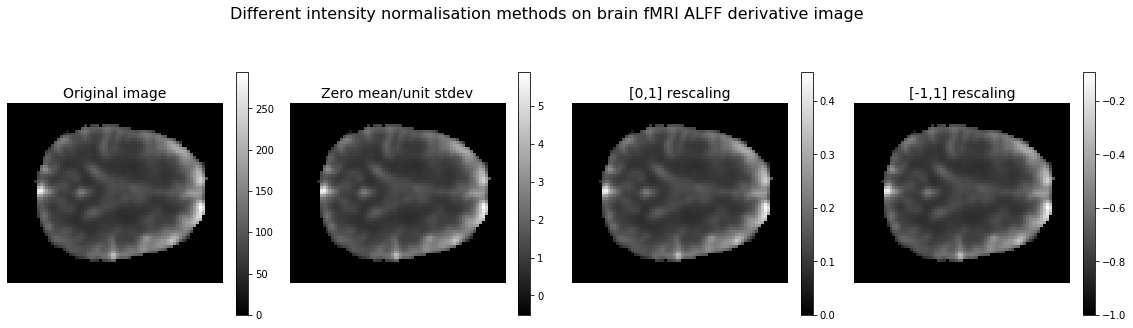

In [7]:
# Visualise using matplotlib.
center_slices = [s//2 for s in arr1.shape]
print(np.squeeze(arr1[center_slices[0], :, :]).shape)


f, axarr = plt.subplots(1, 4, figsize=(20,5));
f.suptitle('Different intensity normalisation methods on brain fMRI ALFF derivative image', fontsize=16)

img = axarr[0].imshow(np.squeeze(arr1[:, :, center_slices[0]]), cmap='gray');
axarr[0].axis('off')
axarr[0].set_title('Original image', fontsize = 14)
f.colorbar(img, ax=axarr[0])

img = axarr[1].imshow(np.squeeze(t1_white[:, :, center_slices[0]]), cmap='gray');
axarr[1].axis('off')
axarr[1].set_title('Zero mean/unit stdev', fontsize=14)
f.colorbar(img, ax=axarr[1])

img = axarr[2].imshow(np.squeeze(t1_norm_zo[:, :, center_slices[0]]), cmap='gray');
axarr[2].axis('off')
axarr[2].set_title('[0,1] rescaling', fontsize=14)
f.colorbar(img, ax=axarr[2])

img = axarr[3].imshow(np.squeeze(t1_norm_oo[:, :, center_slices[0]]), cmap='gray');
axarr[3].axis('off')
axarr[3].set_title('[-1,1] rescaling', fontsize=14)
f.colorbar(img, ax=axarr[3])
    
f.subplots_adjust(wspace=0.05, hspace=0, top=0.8)
plt.show();


In [8]:
# Normalise the dual regression image to zero mean/unit std dev using volume statistics:
t2_white = whitening_3D(arr2)

# Normalise the image to fit [0, 1] range:
t2_norm_zo = normalise_zero_one_3D(arr2)

# Normalise the image to fit [-1, 1] range:
t2_norm_oo = normalise_one_one_3D(arr2)


In [9]:
t2_white.shape


(61, 73, 61, 10)

In [33]:
# Helper function
def myplot(nrows, ncols, zdata, global_title, title, view, savefig, name=None):
    
    center_slices = [s//2 for s in zdata[0].shape]
#     print(np.squeeze(zdata[0][center_slices[0], :, :, 5]).shape)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                       figsize=(5 * ncols, 4 * nrows))
    
    for j in range(nrows):
        for i in range(ncols):
            center_slices_ = [s//2 for s in zdata[i].shape[:-1]]
            img = zdata[i]
            if view == 1:
                img = img[center_slices[0], :, :, j]
            elif view == 2:
                img = img[:, center_slices[0], :, j]
            elif view == 3 :
                img = img[:, :, center_slices[0], j]       
            else :
                print('Valid views 1, 2, 3')
                sys.exit(1)
            cbar = ax[j, i].imshow(np.squeeze(img), cmap='gray', interpolation='nearest', aspect='auto');
            ax[j, i].axis('off')
            ax[j, i].set_title(f'{titles[i]},channel :{j}', size = 24)
            fig.colorbar(cbar, ax=ax[j, i])

    fig.tight_layout()        
    fig.suptitle(global_title, fontsize=24, y=1.005)
    plt.show()
    st = fig.suptitle(global_title,  fontsize=24, y= 1.005)
    if savefig :
        fig.savefig(name, bbox_extra_artists=[st], bbox_inches='tight')



(73, 61)


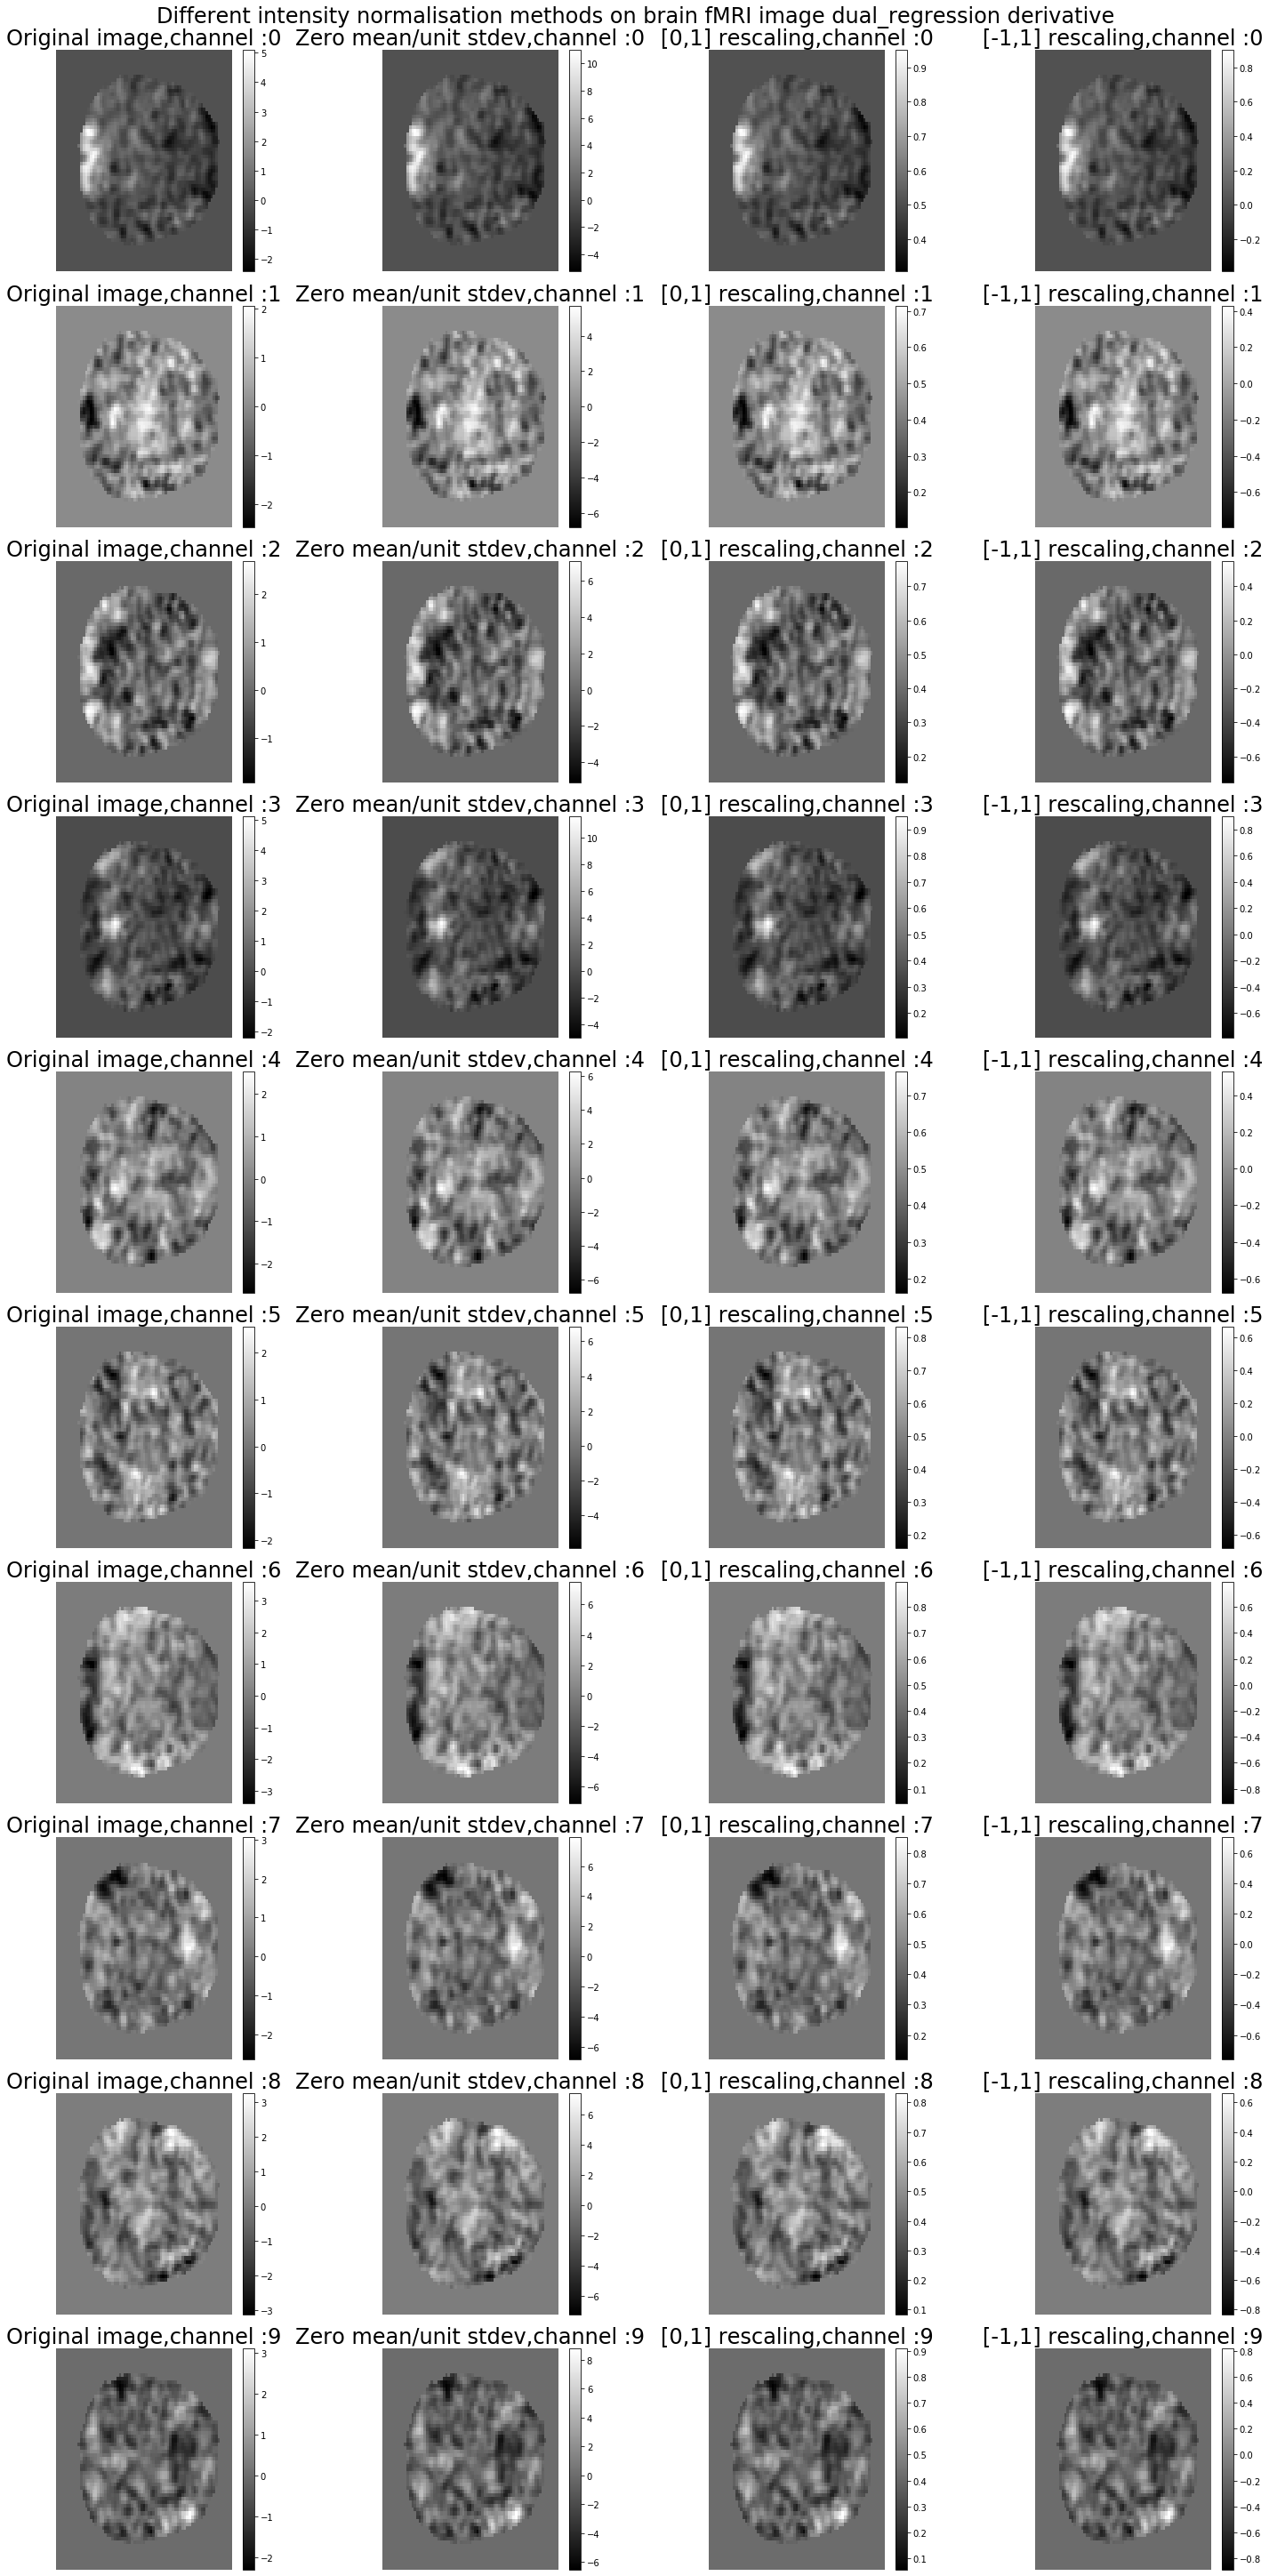

In [11]:
nrows = 10
ncols = 4

global_title ='Different intensity normalisation methods on brain fMRI image dual_regression derivative'
zdata = [arr2, t2_white, t2_norm_zo , t2_norm_oo]
# zdata = [concat_img, concat_img_white, concat_img_zero_one, concat_img_one_one] 
titles =['Original image', 'Zero mean/unit stdev', '[0,1] rescaling', '[-1,1] rescaling']

myplot(nrows, ncols, zdata, global_title, titles, 3, False)



(73, 61)


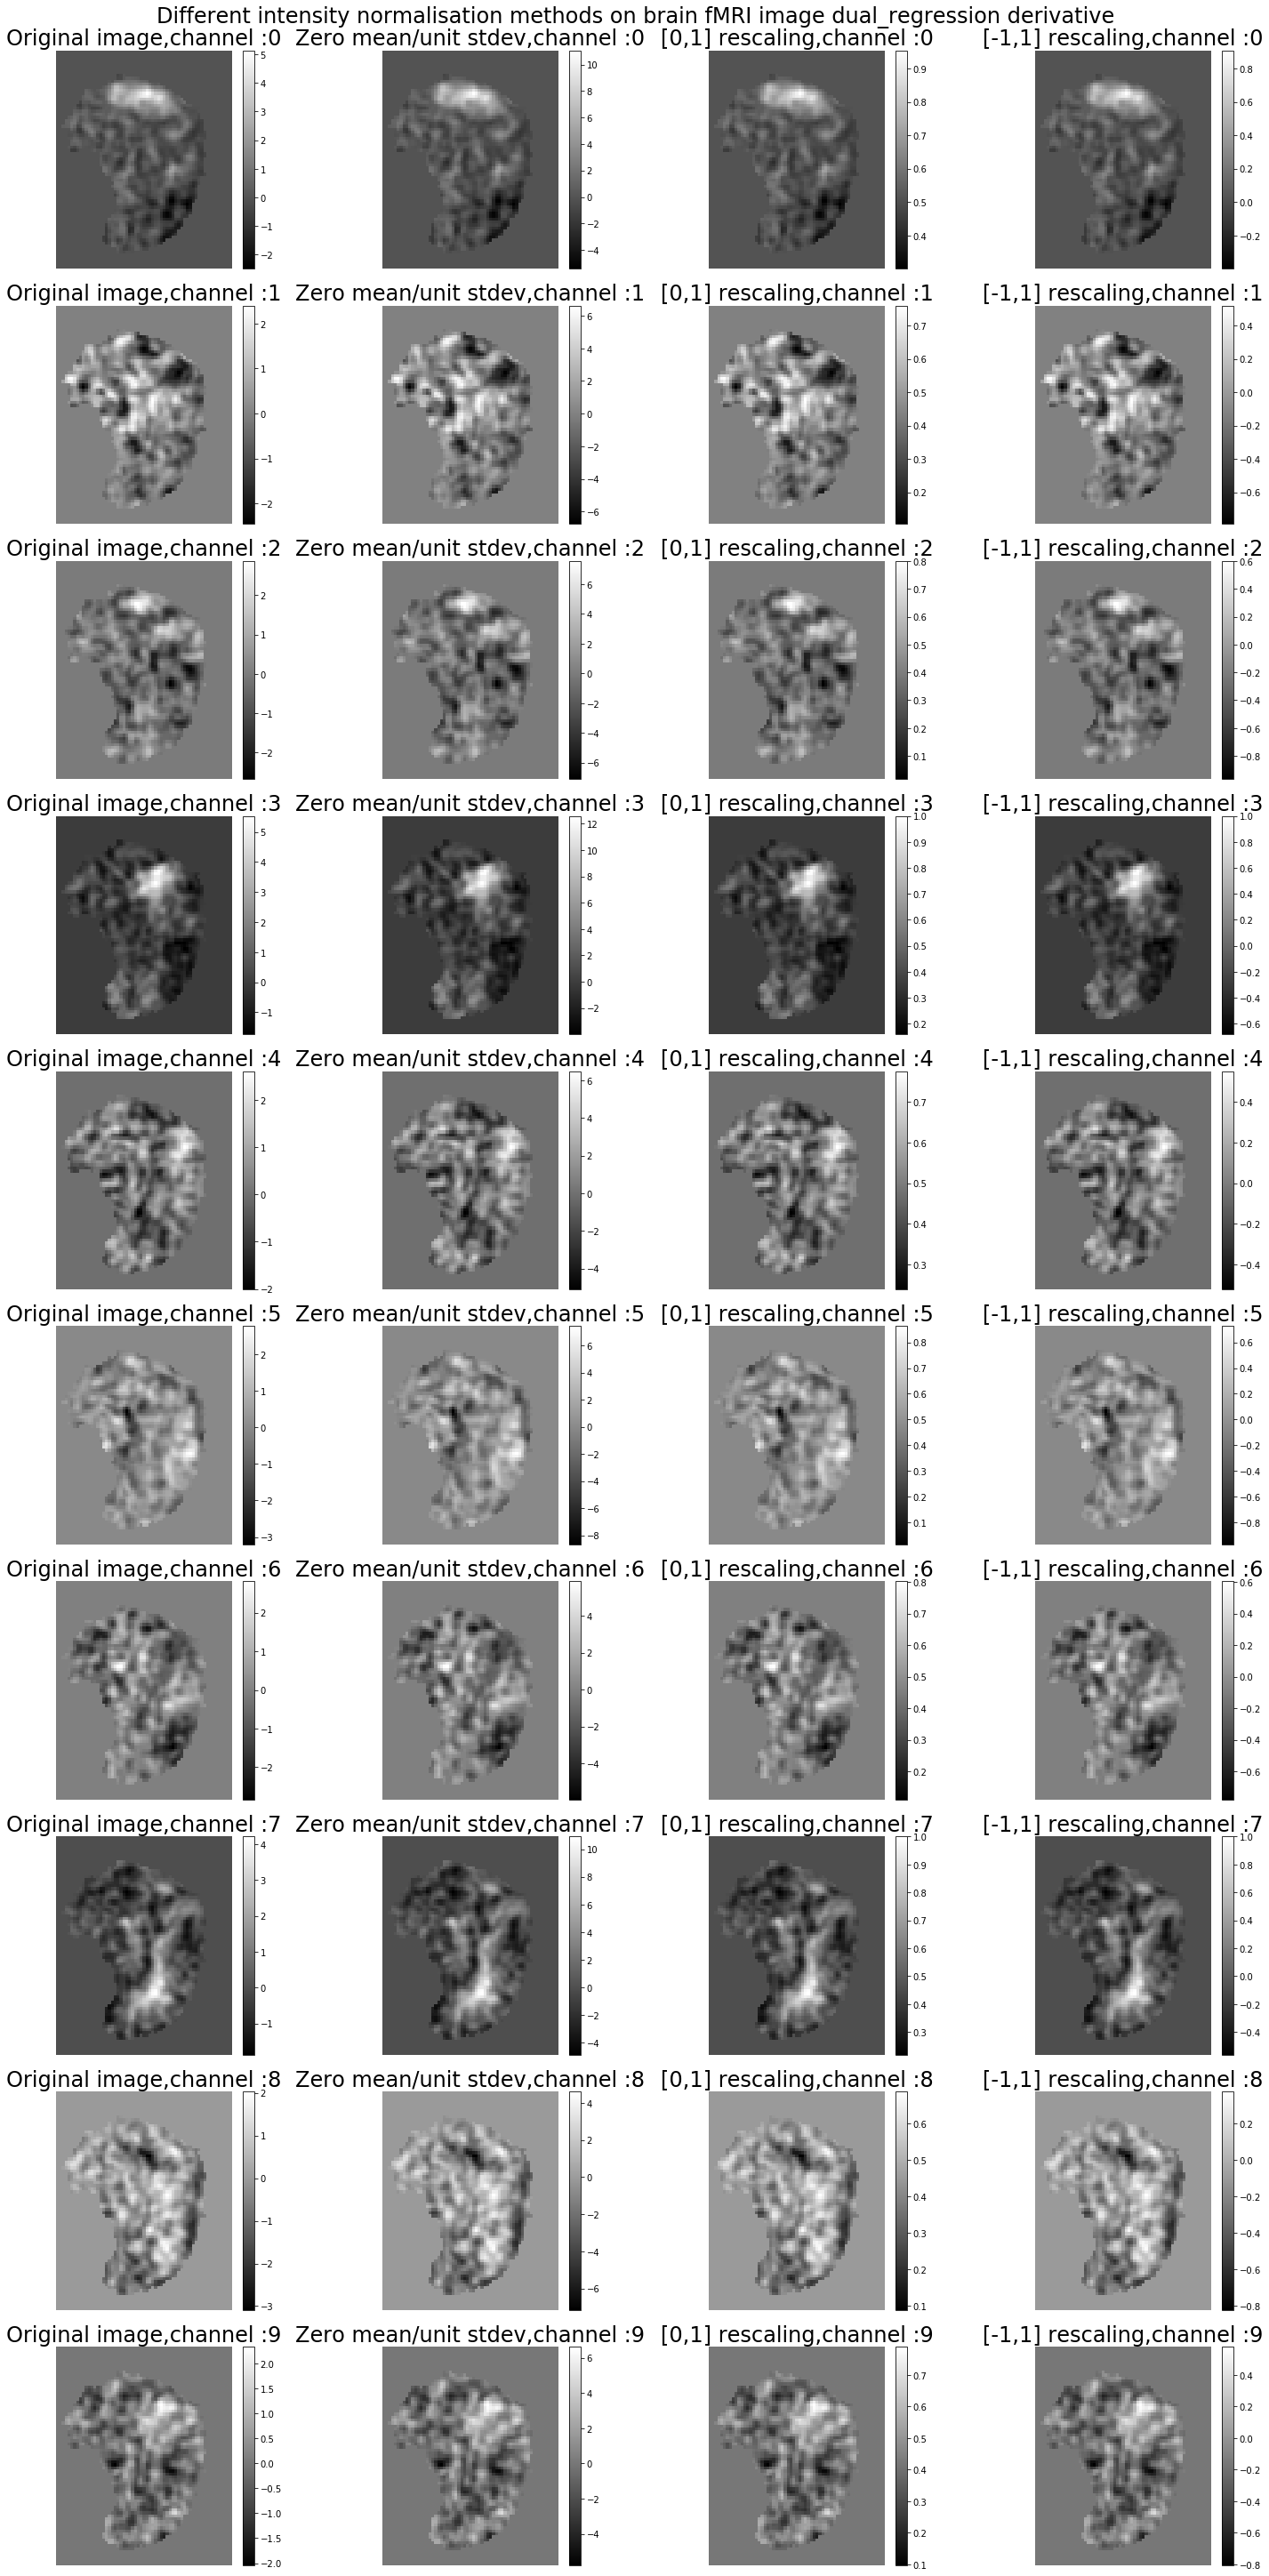

In [12]:
# another view 
nrows = 10
ncols = 4

global_title ='Different intensity normalisation methods on brain fMRI image dual_regression derivative'
zdata = [arr2, t2_white, t2_norm_zo , t2_norm_oo]
# zdata = [concat_img, concat_img_white, concat_img_zero_one, concat_img_one_one] 
titles =['Original image', 'Zero mean/unit stdev', '[0,1] rescaling', '[-1,1] rescaling']

myplot(nrows, ncols, zdata, global_title, titles, 1, False)



# Concatenate images

In [120]:
# here we concatenate the 2 derivatives ALFF, Dual Regression

concat_img = np.concatenate([arr1[:, :, :, np.newaxis], arr2], axis=3)
concat_img_white = np.concatenate([t1_white[:, :, : ,np.newaxis], t2_white], axis=3)
concat_img_zero_one = np.concatenate([t1_norm_zo[:, :, : ,np.newaxis], t2_norm_zo], axis=3)
concat_img_one_one = np.concatenate([t1_norm_oo[:, :, : ,np.newaxis], t2_norm_oo], axis=3)


In [14]:
# # Visualise using matplotlib.
# center_slices = [s//2 for s in concat_img.shape[:1]]
# print(np.squeeze(concat_img[center_slices[0], :, :, 5]).shape)

# for i in range(10):
#     f, axarr = plt.subplots(1, 4, figsize=(20,5),  sharex=True);
#     f.suptitle('Different intensity normalisation methods on brain fMRI image dual_regression + ALFF derivatives')

#     img = axarr[0].imshow(np.squeeze(concat_img[:, :, center_slices[0], i]), cmap='gray');
#     axarr[0].axis('off')
#     axarr[0].set_title('Original image')
#     f.colorbar(img, ax=axarr[0])

#     img = axarr[1].imshow(np.squeeze(concat_img_white[:, :, center_slices[0], i]), cmap='gray');
#     axarr[1].axis('off')
#     axarr[1].set_title('Zero mean/unit stdev')
#     f.colorbar(img, ax=axarr[1])

#     img = axarr[2].imshow(np.squeeze(concat_img_zero_one[:, :, center_slices[0], i]), cmap='gray');
#     axarr[2].axis('off')
#     axarr[2].set_title('[0,1] rescaling')
#     f.colorbar(img, ax=axarr[2])

#     img = axarr[3].imshow(np.squeeze(concat_img_one_one[:, :, center_slices[0], i]), cmap='gray');
#     axarr[3].axis('off')
#     axarr[3].set_title('[-1,1] rescaling')
#     f.colorbar(img, ax=axarr[3])
    
#     f.subplots_adjust(wspace=0.05, hspace=0, top=0.8)
# #     plt.savefig('./TTT.{0:07d}.png'.format(i)) # save each subplot in png 
# plt.show();
   
    

(73, 61)


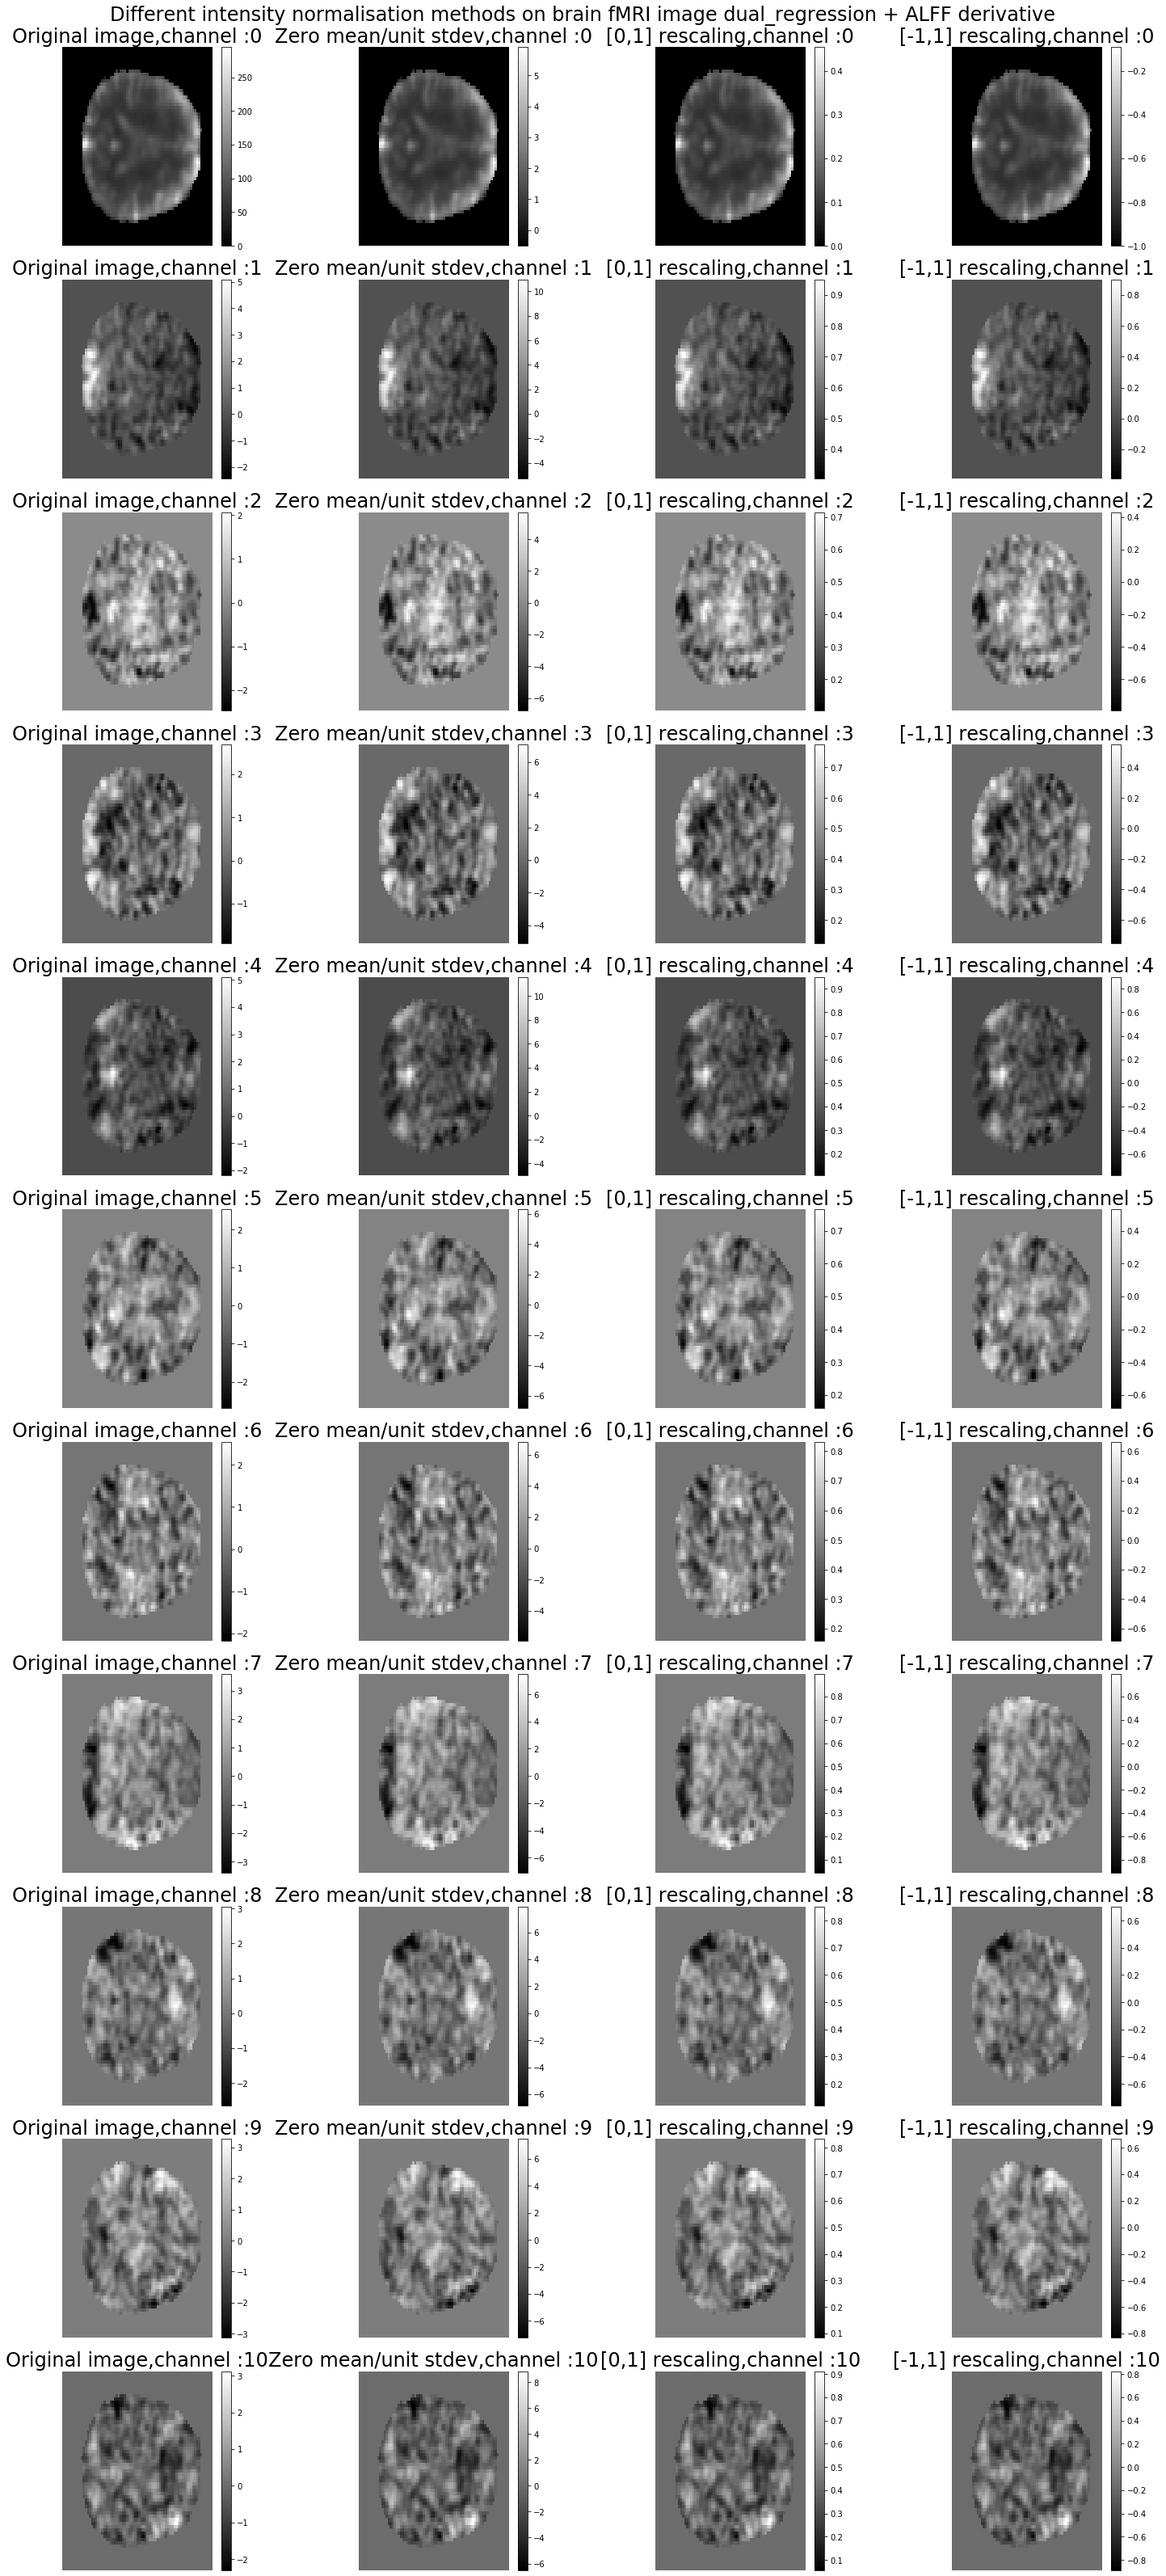

In [121]:
nrows = 11
ncols = 4

global_title ='Different intensity normalisation methods on brain fMRI image dual_regression + ALFF derivative'
zdata = [concat_img, concat_img_white, concat_img_zero_one , concat_img_one_one]
# zdata = [concat_img, concat_img_white, concat_img_zero_one, concat_img_one_one] 
titles =['Original image', 'Zero mean/unit stdev', '[0,1] rescaling', '[-1,1] rescaling']

myplot(nrows, ncols, zdata, global_title, titles, 3, False)



# Augmentations

## Flip

In [19]:
def flip3D(X):
    choice = np.random.randint(3)
    if choice == 0: # flip on x
        X_flip = X[::-1, :, :, :]
    if choice == 1: # flip on y
        X_flip = X[:, ::-1, :, :]
    if choice == 2: # flip on z
        X_flip = X[:, :, ::-1, :]
    print(f'flipped on {choice} axis')
    return X_flip


# def flip_3D(image, random=1):
#     '''
#                 [INPUT]
#     Image -> the input volume to flip. Expected channel last convention
#             i.e. [x,y,z,channels]
#     '''
#     # perform random flip with probability random
#     # if tf.random.uniform(()) <= random:
#     if np.random.rand(1) <= random:
#         #seed = np.round((tf.random.uniform(())*100).numpy(), decimals=0)
#         #seed = tf.random.uniform(())*100
#         '''
#         some augmentation.
#         VERY IMPORTANT!
#         Make sure that the augmentation is applyed on both images and labeles in the same way. To avoid issue, one
#         can concatenate along the channel dimension both the images and labels, apply the augmentation and then
#         split back the labels from the images.
#         '''
        
#         img = image
#         # left-right flip
#         if np.random.rand(1) <= 0.5:
#             img = tf.image.flip_left_right(img)
#         # up-down flip
#         if np.random.rand(1) <= 0.5:
#             img = tf.image.flip_up_down(img)
#         print('flipped')
#         return img
#     else:
#         return image
    

# Rotation

In [13]:
def rotation3D(X):
    
    alpha, beta, gamma = np.random.randint(0, 31, size=3)/180*np.pi
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(alpha), -np.sin(alpha)],
                   [0, np.sin(alpha), np.cos(alpha)]])
    
    Ry = np.array([[np.cos(beta), 0, np.sin(beta)],
                   [0, 1, 0],
                   [-np.sin(beta), 0, np.cos(beta)]])
    
    Rz = np.array([[np.cos(gamma), -np.sin(gamma), 0],
                   [np.sin(gamma), np.cos(gamma), 0],
                   [0, 0, 1]])
    
    R = np.dot(np.dot(Rx, Ry), Rz)
    
    X_rot = np.empty_like(X)
    for channel in range(X.shape[-1]):
        X_rot[:,:,:,channel] = affine_transform(X[:,:,:,channel], 
                                                R, offset=0, order=3, mode='nearest')
    print('rotated')
    return X_rot

# def rot3D(image, random=0.8):
#     # perform random rotation with probability random
#     if np.random.rand(1) <= random:
#         # there is not jet a tf version that performs random rotation. For now using rot90
# #         degree = tf.random.normal(())*np.pi / 180
# #         random_angles = tf.random.uniform(shape = (tf.shape(image)[0], ), minval = 0, maxval = 360)
#         '''
#         some augmentation.
#         VERY IMPORTANT!
#         Make sure that the augmzeroentation is applyed on both images and labeles in the same way. To avoid issue, one
#         can concatenate along the channel dimension both the images and labels, apply the augmentation and then
#         split back the labels from the images.
#         '''

#         angles = [-150, -120, -60, -30,- 15, 15, 30, 60, 120, 150]
#         angle = rnd.choice(angles)
#         print(angle)
#         axis = [0,1]
        
#         rot = [ndimage.rotate(image[:, :, :, c], angle,  axis, reshape=False, mode='nearest') for c in range(image.shape[3])]
#         img = np.stack(rot, axis=3)
#         print('rotated')
#         return img
#     else:
#         return image


## Center Crop

In [14]:
def center_crop_3D(image, central_fraction= 0.85, random=1):
   
    '''
                [INPUT]
    Image -> the input volume to flip. Expected channel last convention
            i.e. [x,y,z,channels]
    '''
    # perform random flip with probability random
    # if tf.random.uniform(()) <= random:
    if np.random.rand(1) <= random:
        #seed = np.round((tf.random.uniform(())*100).numpy(), decimals=0)
        #seed = tf.random.uniform(())*100
        '''
        some augmentation.
        VERY IMPORTANT!
        Make sure that the augmentation is applyed on both images and labeles in the same way. To avoid issue, one
        can concatenate along the channel dimension both the images and labels, apply the augmentation and then
        split back the labels from the images.
        ''' 
        img = tf.image.central_crop(image, central_fraction)
        print('centered')
        return img.numpy()
    else:
        return image


## Blur

In [15]:
def blur3D(image):
    
    blur_img = ndimage.gaussian_filter(image, sigma = 1.2)
    print('blurred')
    
    return blur_img


## Elastic deformation

In [16]:
def elastic3D(X):
    """
    Elastic deformation on a image and its target
    """
    X = [X[:, :, :, c] for c in range(X.shape[3])]
    
    Xel = elasticdeform.deform_random_grid(X, sigma=3, axis=(0, 1, 2), order = 2)
    
    Xel = np.stack(Xel, axis=3)       
    print('deformed')
    
    return Xel


## Zoom

In [26]:
def pad(image, new_shape, border_mode="constant", value=0):
    '''
    image: [H, W, D, C] or [H, W, D]
    new_shape: [H, W, D]
    '''
    axes_not_pad = len(image.shape) - len(new_shape)

    old_shape = np.array(image.shape[:len(new_shape)])
    new_shape = np.array([max(new_shape[i], old_shape[i]) for i in range(len(new_shape))])

    difference = new_shape - old_shape
    pad_below = difference // 2
    pad_above = difference - pad_below

    pad_list = [list(i) for i in zip(pad_below, pad_above)] + [[0, 0]] * axes_not_pad

    if border_mode == 'reflect':
        res = np.pad(image, pad_list, border_mode)
    elif border_mode == 'constant':
        res = np.pad(image, pad_list, border_mode, constant_values=value)
    else:
        raise ValueError

    return res

def get_center_crop_coords(height, width, depth, crop_height, crop_width, crop_depth):
    x1 = (height - crop_height) // 2
    x2 = x1 + crop_height
    y1 = (width - crop_width) // 2
    y2 = y1 + crop_width
    z1 = (depth - crop_depth) // 2
    z2 = z1 + crop_depth
    return x1, y1, z1, x2, y2, z2


def center_crop(img):
    crop_height, crop_width, crop_depth = 58, 63, 58
    height, width, depth = img.shape[:3]
    if height < crop_height or width < crop_width or depth < crop_depth:
        raise ValueError
    x1, y1, z1, x2, y2, z2 = get_center_crop_coords(height, width, depth, crop_height, crop_width, crop_depth)
    
    im = [img[x1:x2, y1:y2, z1:z2, c] for c in range(img.shape[3])]
    im = [pad(img, (61, 73, 61)) for img in im]
#     print(im[5].shape)
    Xcenter = np.stack(im, axis = 3)
    print('centered')
    return Xcenter


In [169]:
start_time = time.time()

concat_img_flip = flip3D(concat_img_zero_one)
# print(concat_img_flip.shape)
concat_img_rotation = rotation3D(concat_img_zero_one)
# print(concat_img_rotation.shape)
concat_img_center = center_crop(concat_img_zero_one)
# print(concat_img_zoom.shape)
concat_img_blur = blur3D(concat_img_zero_one)
# print(concat_img_blur.shape)
concat_img_elastic = elastic3D(concat_img_zero_one)
# print(concat_img_elastic.shape)

elapsed_time = time.time() - start_time
elapsed_time_string = str(datetime.timedelta(seconds=round(elapsed_time)))
print('Training time: ', elapsed_time_string)



flipped on 1 axis
rotated
(61, 73, 61)
centered
blurred
deformed
Training time:  0:00:04


(73, 61)


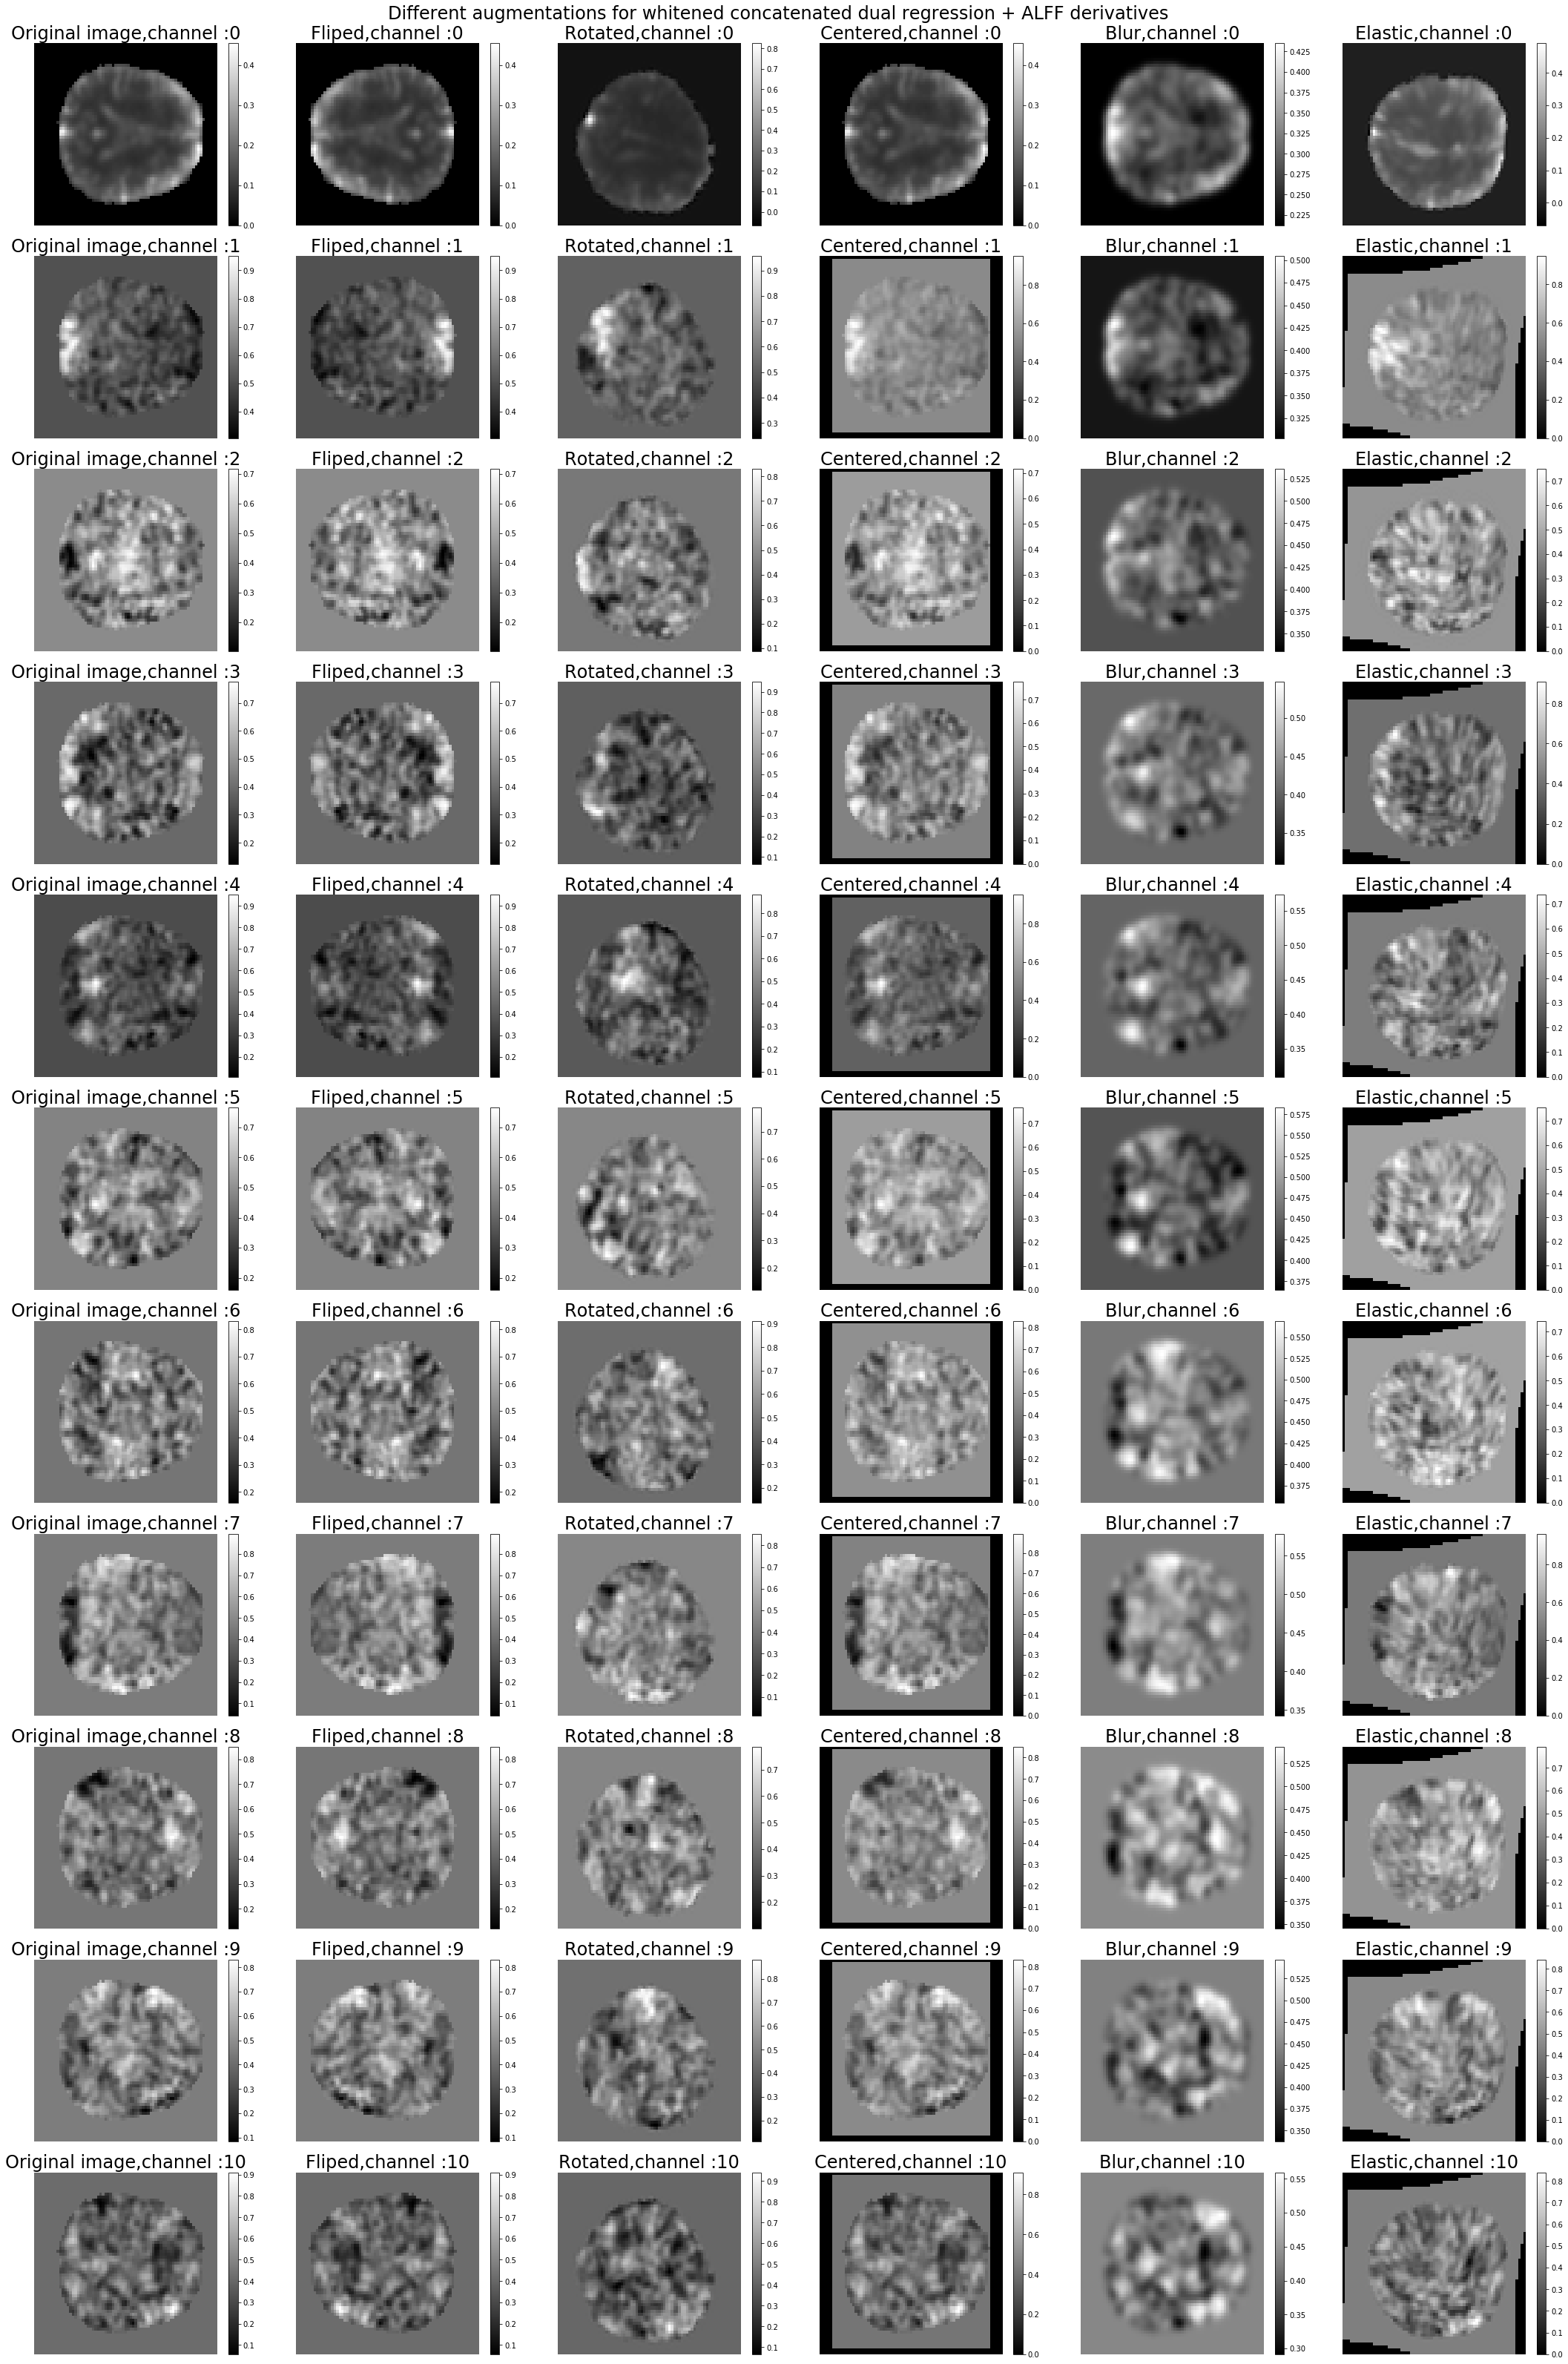

In [170]:
nrows = 11
ncols = 6

global_title ='Different augmentations for whitened concatenated dual regression + ALFF derivatives'
zdata = [concat_img_zero_one, concat_img_flip, concat_img_rotation, 
         concat_img_center, concat_img_blur, concat_img_elastic]

titles =['Original image', 'Fliped','Rotated', 'Centered', 'Blur', 'Elastic']

myplot(nrows, ncols, zdata, global_title, titles, 3, True, 'augmentations')



In [22]:
t1_norm_zo.shape
t1_norm_zo_ex = t1_norm_zo[:,:, :, np.newaxis]
print(t1_norm_zo_ex.shape)

(61, 73, 61, 1)


In [41]:
start_time = time.time()

alff_img_flip = flip3D(t1_norm_zo_ex)
# print(concat_img_flip.shape)
alff_img_rotation = rotation3D(t1_norm_zo_ex)
# print(concat_img_rotation.shape)
alff_img_center = center_crop(t1_norm_zo_ex)
# print(concat_img_zoom.shape)
alff_img_blur = blur3D(t1_norm_zo_ex)
# print(concat_img_blur.shape)
alff_img_elastic = elastic3D(t1_norm_zo_ex)
# print(concat_img_elastic.shape)

elapsed_time = time.time() - start_time
elapsed_time_string = str(datetime.timedelta(seconds=round(elapsed_time)))
print('Training time: ', elapsed_time_string)


flipped on 1 axis
rotated
centered
blurred
deformed
Training time:  0:00:01


(73, 61)


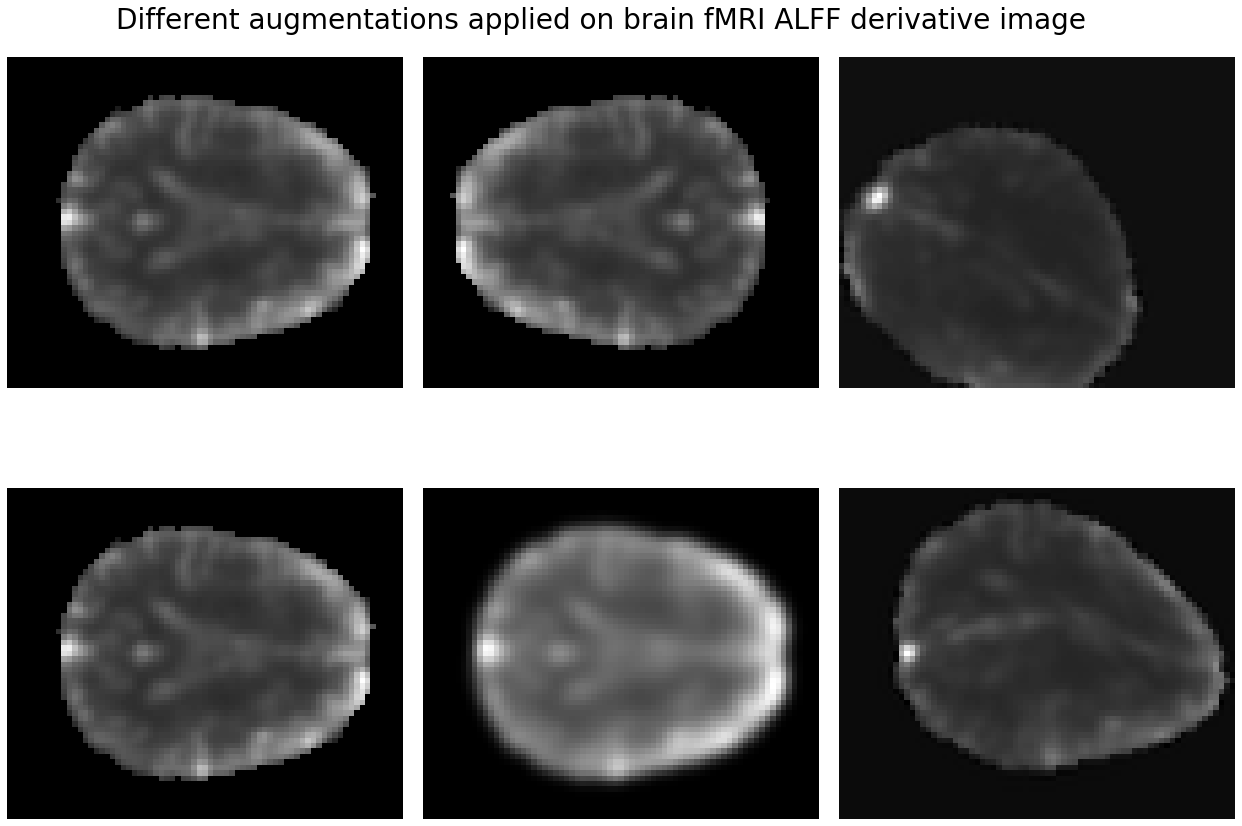

In [126]:
# nrows = 1
# ncols = 6

# global_title ='Different augmentations for whitened concatenated ALFF derivative'
# zdata = [t1_norm_zo_ex, alff_img_flip, alff_img_rotation, 
#          alff_img_center, alff_img_blur, alff_img_elastic]

# titles =['Original image', 'Fliped','Rotated', 'Centered', 'Blur', 'Elastic']

# myplot(nrows, ncols, zdata, global_title, titles, 3, True, 'augmentations_alff')


# Visualise using matplotlib.
center_slices = [s//2 for s in t1_norm_zo_ex.shape]
print(np.squeeze(t1_norm_zo_ex[center_slices[0], :, :]).shape)


f, axarr = plt.subplots(2, 3, figsize=(22, 14));
f.suptitle('Different augmentations applied on brain fMRI ALFF derivative image', fontsize=28)

img = axarr[0, 0].imshow(np.squeeze(t1_norm_zo_ex[:, :, center_slices[0], :]), cmap='gray');
axarr[0, 0].axis('off')
axarr[0, 0].set_title('', fontsize = 20)
# f.colorbar(img, ax=axarr[0])

img = axarr[0,1].imshow(np.squeeze(alff_img_flip[:, :, center_slices[0], :]), cmap='gray');
axarr[0, 1].axis('off')
axarr[0, 1].set_title('', fontsize=20)
# f.colorbar(img, ax=axarr[1])

img = axarr[0, 2].imshow(np.squeeze(alff_img_rotation[:, :, center_slices[0], :]), cmap='gray');
axarr[0, 2].axis('off')
axarr[0, 2].set_title('', fontsize=20)
# f.colorbar(img, ax=axarr[2])

img = axarr[1, 0].imshow(np.squeeze(alff_img_center[:, :, center_slices[0], :]), cmap='gray');
axarr[1, 0].axis('off')
axarr[1, 0].set_title('', fontsize=20)
# f.colorbar(img, ax=axarr[3])

img = axarr[1, 1].imshow(np.squeeze(alff_img_blur[:, :, center_slices[0], :]), cmap='gray');
axarr[1, 1].axis('off')
axarr[1, 1].set_title('', fontsize=20)
# # f.colorbar(img, ax=axarr[3])

img = axarr[1, 2].imshow(np.squeeze(alff_img_elastic[:, :, center_slices[0], :]), cmap='gray');
axarr[1, 2].axis('off')
axarr[1, 2].set_title('', fontsize=20)
# f.colorbar(img, ax=axarr[3])    
    
f.subplots_adjust(wspace=0.05, hspace=0, top=0.98)
plt.show();
name ='augmentations_alff'
global_title = ''
savefig = True
st = f.suptitle(global_title,  fontsize=24, y= 1.005)
if savefig :
    f.savefig(name, bbox_extra_artists=[st], bbox_inches='tight')



# Make augmented batch

In [23]:
def random_decisions(N):
    """
    Generate N random decisions for augmentation
    N should be equal to the batch size
    """
    
    decisions = np.zeros((N, 4)) # 4 is number of aug techniques to combine
    for n in range(N):
        decisions[n] = np.random.randint(2, size=4)
        
    return decisions

def combine_aug(X, do):
    """
    Combine randomly the different augmentation techniques written above
    """
    Xnew = X
    
    if do[0] == 1:
        Xnew = flip3D(Xnew)
        
    if do[1] == 1:
        
        Xnew = Xnew   
        
    if do[2] == 1:
        Xnew = rotation3D(Xnew)
        
    if do[3] == 1:
        Xnew = elastic3D(Xnew)
        
    return Xnew

def aug_batch(Xb):
    """
    Generate a augmented image batch 
    """
    batch_size = len(Xb)
    newXb = np.empty_like(Xb)
    print(newXb.shape)
    decisions = random_decisions(batch_size)
    
    inputs = [(X, do) for X, do in zip(Xb, decisions)]
    print(inputs[0][0].shape)
    pool = mp.Pool(processes=8)
    multi_result = pool.starmap(combine_aug, inputs)
    pool.close()
    
    for i in range(len(Xb)):
        newXb[i] = multi_result[i][0]
        
    return newXb


In [24]:
res = aug_batch(np.array([concat_img]))


(1, 61, 73, 61, 11)
(61, 73, 61, 11)


In [25]:
res.shape


(1, 61, 73, 61, 11)

# Resize

In [26]:
def resize_slices(img):
    
    """Resize the Width and Height"""
    # resize all slices
    flatten = [
        cv2.resize(img[:, :, :, i], (73, 73), interpolation=cv2.INTER_CUBIC)
        for i in range(img.shape[-1])
    ]
    # stack along the z-axis
    img = np.array(np.stack(flatten, axis=3))
    return img

def resize_depth(img):
    """Resize across Depth"""
    # set the desired depth
    desired_depth = 73
    # get current depth
    current_depth = img.shape[2]
    # compute depth factor
    depth = current_depth / desired_depth
    depth_factor = 1 / depth
    print(depth_factor)
    # resize across z-axis

    im = [ndimage.zoom(img[: ,: :, i], (1, 1, depth_factor), mode="nearest") 
          for i in range(img.shape[3])]

    img_new = np.stack(im, axis=3) 
    return img_new


In [27]:
resized = resize_slices(concat_img_zero_one)

resized = resize_depth(resized)


1.1967213114754098


In [28]:
resized.shape


(73, 73, 13, 11)

(73, 61)


IndexError: index 30 is out of bounds for axis 2 with size 13

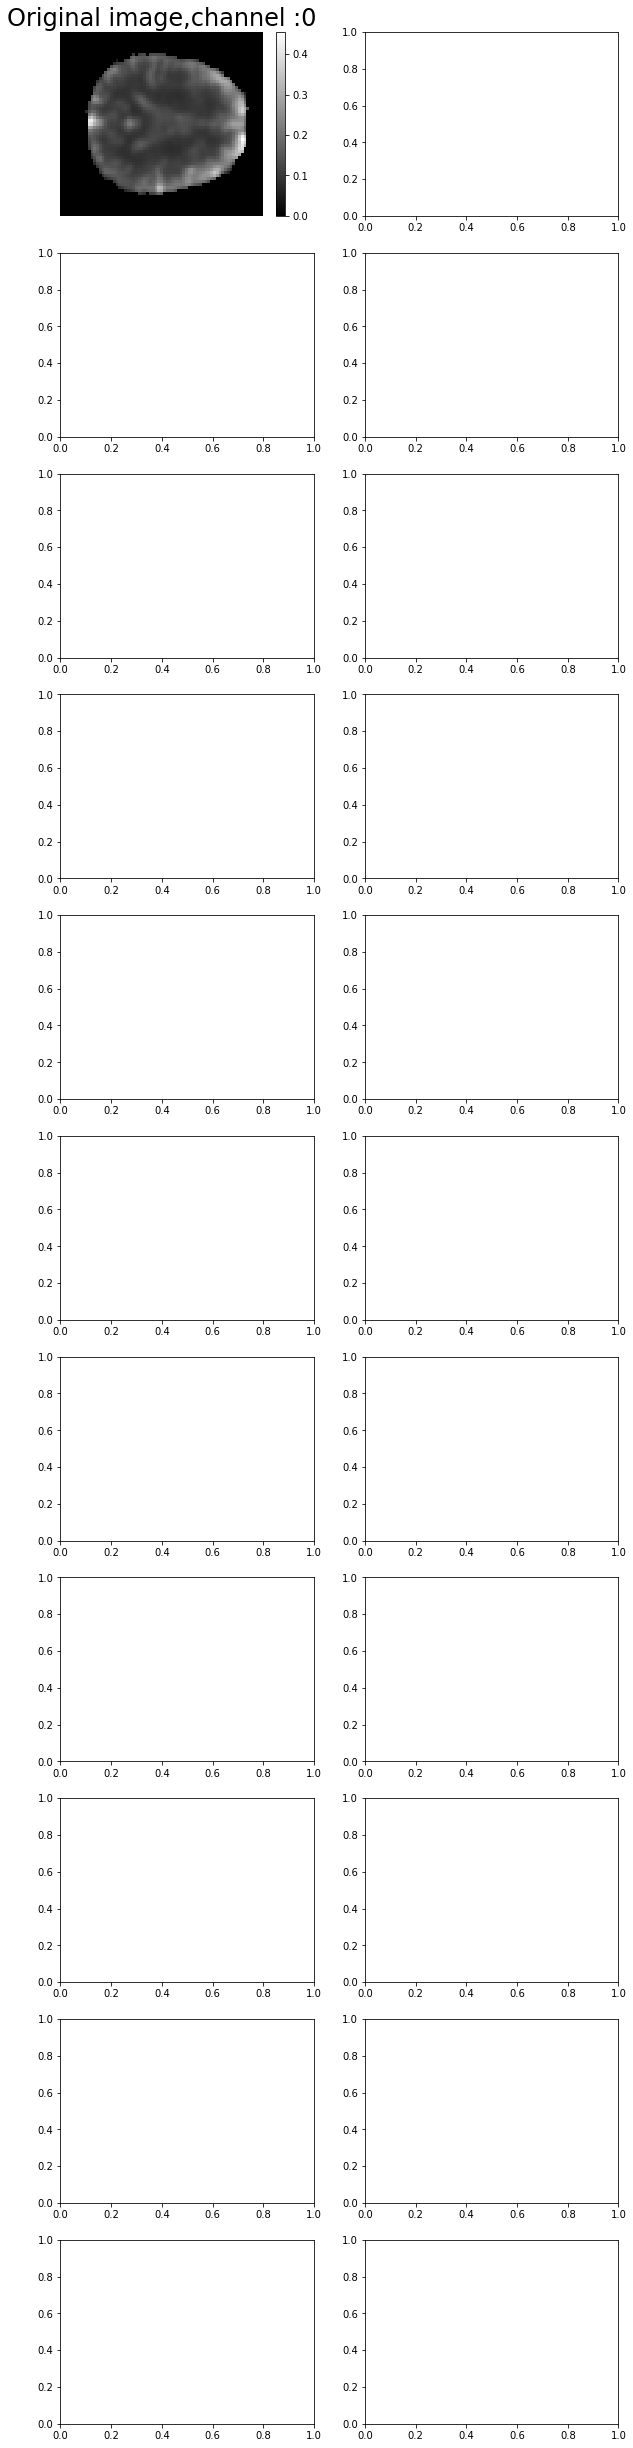

In [29]:
nrows = 11
ncols = 2

global_title ='Original and resized image'
zdata = [concat_img_zero_one, resized]

titles =['Original image', 'Resized']

myplot(nrows, ncols, zdata, global_title, titles, 3, True, 'augmentations')


[30, 36, 30, 5]
(73, 61, 11)


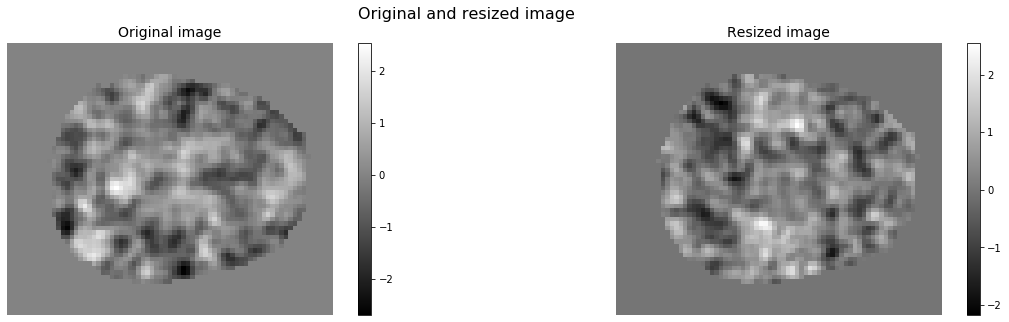

In [30]:
# Visualise using matplotlib.
center_slices = [s//2 for s in concat_img.shape]
print(center_slices)
print(np.squeeze(concat_img[center_slices[0], :, :]).shape)

f, axarr = plt.subplots(1, 2, figsize=(20,5));
f.suptitle('Original and resized image', fontsize=16)

img = axarr[0].imshow(np.squeeze(concat_img[:, :, center_slices[0], 5]), cmap='gray');
axarr[0].axis('off')
axarr[0].set_title('Original image', fontsize = 14)
f.colorbar(img, ax=axarr[0])

img = axarr[1].imshow(np.squeeze(arr2[:, :, center_slices[0], 5]), cmap='gray');
axarr[1].axis('off')
axarr[1].set_title('Resized image', fontsize=14)
f.colorbar(img, ax=axarr[1])


# Visualize the derivatives

In [31]:
derivatives = ['alff','degree_binarize','degree_weighted', 
               'eigenvector_binarize', 'eigenvector_weighted', 
               'dual_regression','falff',
               'lfcd', 'reho', 'vmhc']

img = []

for derivative in derivatives:
    path = f'DATA/{derivative}/ASD/KKI_0050792_{derivative}.nii.gz'
    current = nib.load(path).get_fdata()
    print(f'{derivative}-->{current.shape}')
    img.append(current)

im = [img[i][:, : ,:, np.newaxis] if img[i].ndim==3 else img[i] for i in range(len(img))]

im = np.concatenate(im, axis = 3)
print(im.shape)


alff-->(61, 73, 61)
degree_binarize-->(61, 73, 61)
degree_weighted-->(61, 73, 61)
eigenvector_binarize-->(61, 73, 61)
eigenvector_weighted-->(61, 73, 61)
dual_regression-->(61, 73, 61, 10)
falff-->(61, 73, 61)
lfcd-->(61, 73, 61)
reho-->(61, 73, 61)
vmhc-->(61, 73, 61)
(61, 73, 61, 19)


In [32]:
im_norm_one_one = normalise_one_one_3D(im)


(73, 61)


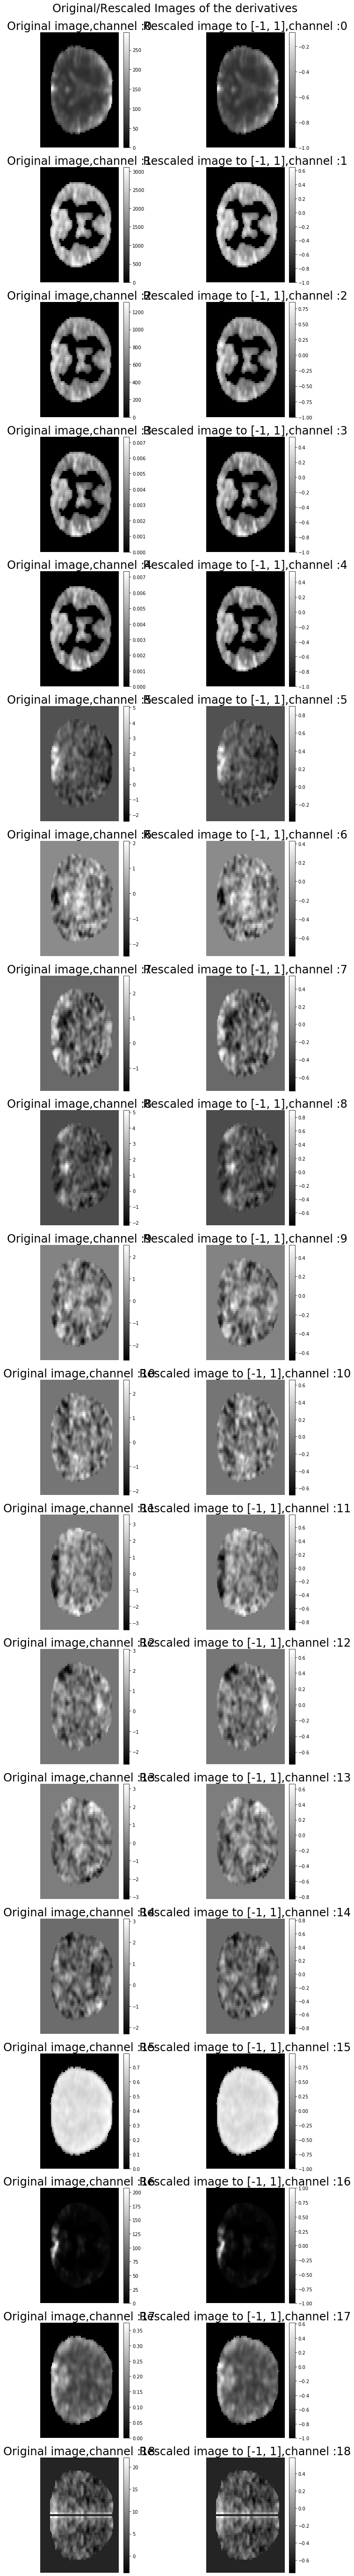

In [33]:
nrows = 19
ncols = 2

global_title ='Original/Rescaled Images of the derivatives'
zdata = [im, im_norm_one_one]

titles =['Original image', 'Rescaled image to [-1, 1]']

myplot(nrows, ncols, zdata, global_title, titles, 3, False)


In [34]:
img32 = nib.load('DATA/degree_binarize/ASD/KKI_0050792_degree_binarize.nii.gz') # dual regression image
arr32 = img32.get_fdata()
arr32.shape


(61, 73, 61)

(73, 61)


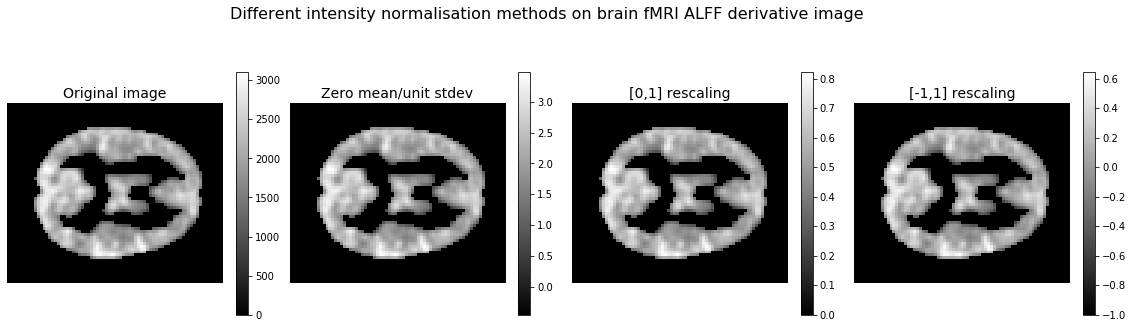

In [35]:
# Normalise the ALFF image to zero mean/unit std dev using volume statistics:
t32_white = whitening(arr32)

# Normalise the image to fit [0, 1] range:
t32_norm_zo = normalise_zero_one(arr32)

# Normalise the image to fit [-1, 1] range:
t32_norm_oo = normalise_one_one(arr32)


# Visualise using matplotlib.
center_slices = [s//2 for s in arr32.shape]
print(np.squeeze(arr32[center_slices[0], :, :]).shape)


f, axarr = plt.subplots(1, 4, figsize=(20,5));
f.suptitle('Different intensity normalisation methods on brain fMRI ALFF derivative image', fontsize=16)

img = axarr[0].imshow(np.squeeze(arr32[:, :, center_slices[0]]), cmap='gray');
axarr[0].axis('off')
axarr[0].set_title('Original image', fontsize = 14)
f.colorbar(img, ax=axarr[0])

img = axarr[1].imshow(np.squeeze(t32_white[:, :, center_slices[0]]), cmap='gray');
axarr[1].axis('off')
axarr[1].set_title('Zero mean/unit stdev', fontsize=14)
f.colorbar(img, ax=axarr[1])

img = axarr[2].imshow(np.squeeze(t32_norm_zo[:, :, center_slices[0]]), cmap='gray');
axarr[2].axis('off')
axarr[2].set_title('[0,1] rescaling', fontsize=14)
f.colorbar(img, ax=axarr[2])

img = axarr[3].imshow(np.squeeze(t32_norm_oo[:, :, center_slices[0]]), cmap='gray');
axarr[3].axis('off')
axarr[3].set_title('[-1,1] rescaling', fontsize=14)
f.colorbar(img, ax=axarr[3])
    
f.subplots_adjust(wspace=0.05, hspace=0, top=0.8)
plt.show();


In [36]:
derivatives = ['alff','degree_binarize','degree_weighted', 
               'eigenvector_binarize', 'eigenvector_weighted', 
               'falff', 'lfcd', 'reho', 'vmhc']

img = []

for derivative in derivatives:
    path = f'DATA/{derivative}/ASD/KKI_0050792_{derivative}.nii.gz'
    current = nib.load(path).get_fdata()
    print(f'{derivative}-->{current.shape}')
    img.append(current)

im = [img[i][:, : ,:, np.newaxis] if img[i].ndim==3 else img[i] for i in range(len(img))]

im = np.concatenate(im, axis = 3)
print(im.shape)


alff-->(61, 73, 61)
degree_binarize-->(61, 73, 61)
degree_weighted-->(61, 73, 61)
eigenvector_binarize-->(61, 73, 61)
eigenvector_weighted-->(61, 73, 61)
falff-->(61, 73, 61)
lfcd-->(61, 73, 61)
reho-->(61, 73, 61)
vmhc-->(61, 73, 61)
(61, 73, 61, 9)


In [37]:
im_norm_one_one = normalise_one_one_3D(im)


In [33]:
# Helper function
def myplot_derivatives(nrows, ncols, zdata, global_title, title, view, savefig, name=None):
    
    center_slices_ = [s//2 for s in zdata[0].shape[:-1]]
    print(center_slices)
    print(np.squeeze(zdata[0][center_slices[0], :, :, 5]).shape)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                       figsize=(65 * ncols, 64 * nrows))
    
    for j in range(nrows):
        for i in range(ncols):
            img = zdata[0][:, :, :, i]
#             print(f'the image shape is {img.shape}')
            if view == 1:
                img = img[center_slices[0], :, :]
            elif view == 2:
                img = img[:, center_slices[1], :]
            elif view == 3 :
                img = img[:, :, center_slices[2]]       
            else :
                print('Valid views 1, 2, 3')
                sys.exit(1)
            cbar = ax[i].imshow(np.squeeze(img), cmap='gray', interpolation='nearest', aspect='auto');
            ax[i].axis('off')
            ax[i].set_title(f'{titles[i]}', size = 34)
#             fig.colorbar(cbar, ax=ax[i])

    fig.tight_layout()        
    fig.suptitle(global_title, fontsize=64, y=1.005)
    plt.show()
    st = fig.suptitle(global_title,  fontsize=64, y= 1.005)
    if savefig :
        fig.savefig(name, bbox_extra_artists=[st], bbox_inches='tight')



In [34]:
nrows = 1
ncols = 9

global_title ='Original/Rescaled Images of the derivatives'
zdata = [im_norm_one_one]

titles = derivatives

myplot_derivatives(nrows, ncols, zdata, global_title, titles, 3, True, '9_derivatives')


[30, 36, 30]
(73, 61)


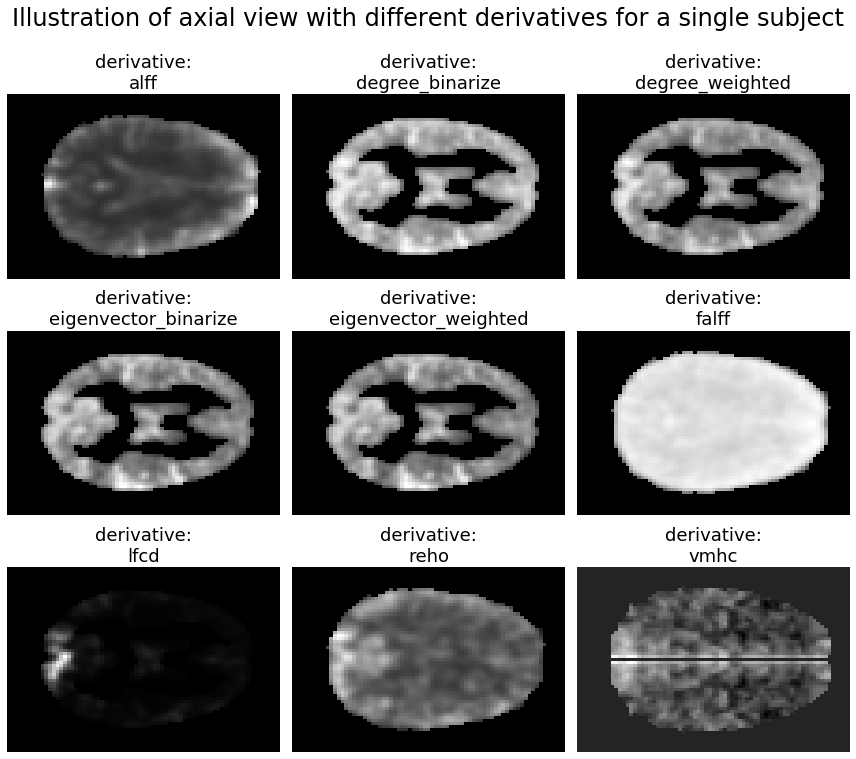

In [35]:
plt.figure(figsize=(12,10))
plt.subplots_adjust(hspace=0.5)
center_slices_ = [s//2 for s in im_norm_one_one.shape[:-1]]
for i in range(9):
    img = im_norm_one_one[:, :, center_slices[2], i ] 
    plt.subplot(3,3,i+1)
    plt.imshow(np.squeeze(img), cmap='gray', interpolation='nearest', aspect='auto');
    plt.title(f"derivative:\n{derivatives[i]}",color = 'black', size=18)
    plt.axis('off')

# _ = plt.suptitle("Intel-images predictions", color='black', size=20)

plt.tight_layout()        

st = plt.suptitle('Illustration of axial view with different derivatives for a single subject',  fontsize=24, y= 1.05)
plt.savefig('9_derivatives', bbox_extra_artists=[st], bbox_inches='tight')


In [36]:
dr = f'DATA/dual_regression/ASD/KKI_0050792_dual_regression.nii.gz'
dr_image = nib.load(dr).get_fdata()
dr_image.shape


(61, 73, 61, 10)

In [37]:
im_norm_one_one_dr = normalise_one_one_3D(dr_image)


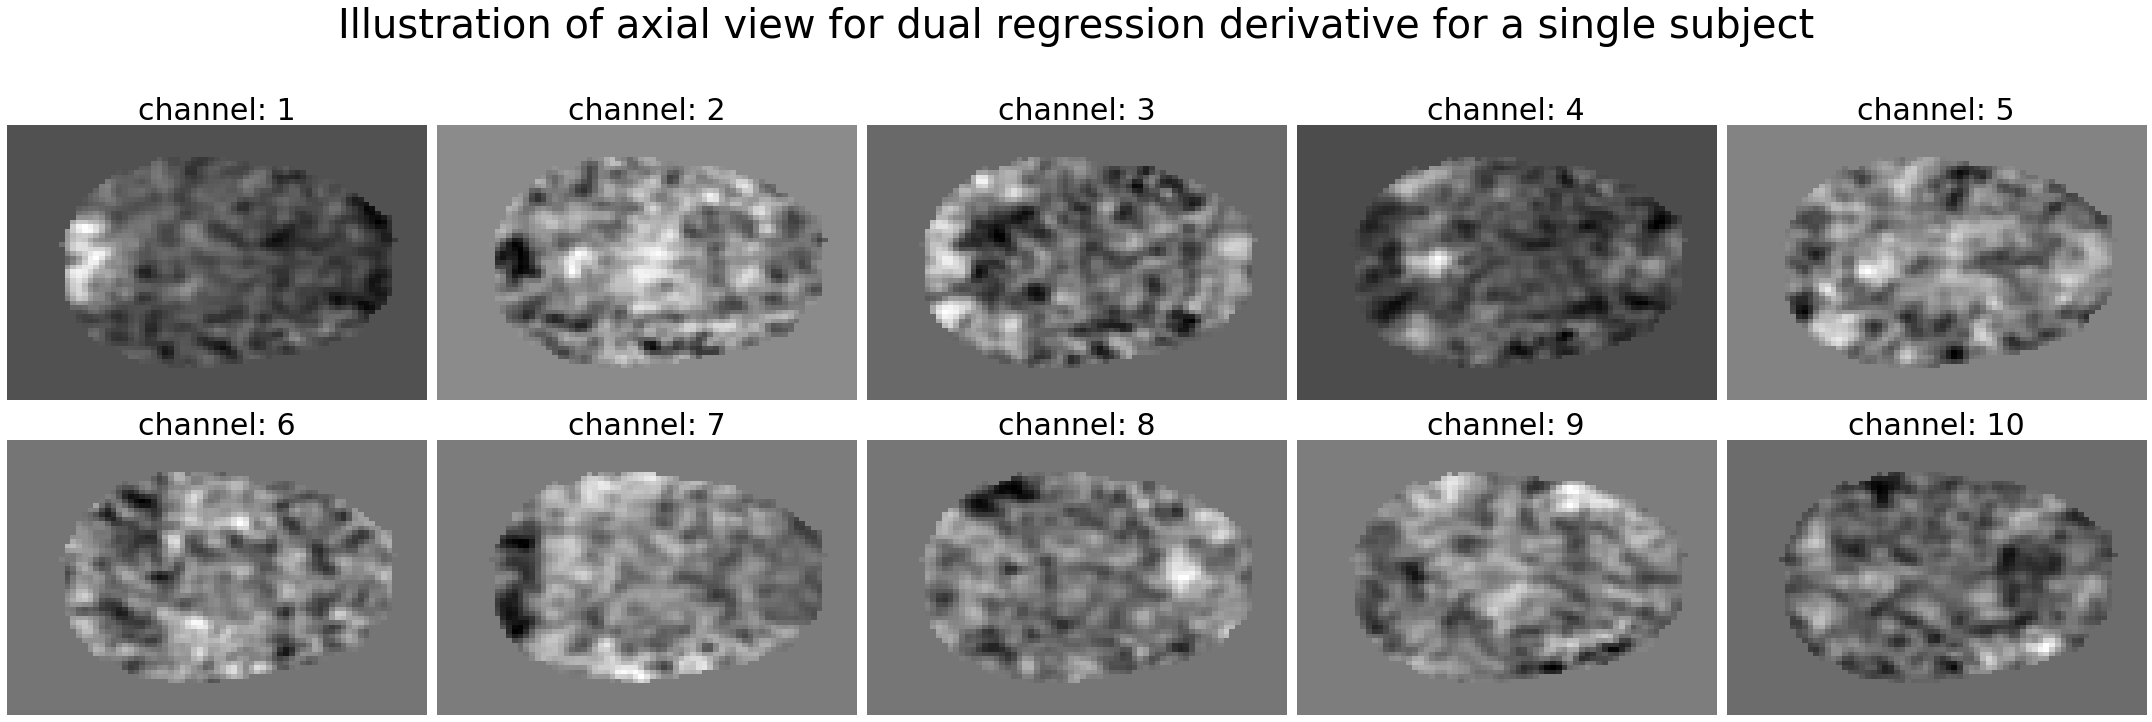

In [40]:
plt.figure(figsize=(30,22))
plt.subplots_adjust(hspace=0.5)
center_slices_ = [s//2 for s in im_norm_one_one_dr.shape[:-1]]
for i in range(10):
    img = im_norm_one_one_dr[:, :, center_slices[2], i ] 
    plt.subplot(5,5,i+1)
    plt.imshow(np.squeeze(img), cmap='gray', interpolation='nearest', aspect='auto');
    plt.title(f"channel: {i+1}",color = 'black', size=30)
    plt.axis('off')

plt.tight_layout()        

st = plt.suptitle('Illustration of axial view for dual regression derivative for a single subject',  fontsize=40, y= 1.05)
plt.savefig('dual_regression', bbox_extra_artists=[st], bbox_inches='tight')
